Technical Analysis libraries:   
* pip install TA-Lib         ---- 150 + indicators, supports work with pandasd. TA-Lib is the golden standard, but it is not the easiest one to understand and dive deep into.
* pip install --upgrade ta   ---- 42 indicators, supports work with pandas. ( Can run all 42 indicators in one line of code).  
* pip install pandas_ta      ---- 130+ indicators, supports work with pandas.   

*** Read more here : https://medium.com/geekculture/top-4-python-libraries-for-technical-analysis-db4f1ea87e09

Portfolio Assessment libraries:
* pip install pyfolio -- Portfolio analysis (seems like it is not supported anymore)

In [148]:
import requests as r
import pandas as pd 
import numpy as np
import json as j
import time
from datetime import timedelta
from datetime import datetime 
from scipy.stats import geom

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
import seaborn as sns
import os
import shutil
from Scraping import Navigation as Nav
from Data_Retrieval_Transformation import AlphaVantageAPI as AV
from Data_Retrieval_Transformation import OtherData, Analysis
from Data_Retrieval_Transformation import Indicators as Ind
from Data_Retrieval_Transformation import AV_Plots
import ta 


MARKETS = ['NASDAQ', 'NYSE']
LAST_DAY_DATA_DIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\Stock Analysis\P1-Indicators-Chart-Analysis\Data\Last Day'
STOCK_LIST = ['VUG'] # 


# API Settings
import yaml
def load_yaml_file(filename):
    with open(filename, "r") as file:
        data = yaml.safe_load(file)
    return data

KEY = load_yaml_file(r"C:\Users\Vasyl\Google Drive\Vantage API Secret key\AlphaVantageAPIPremiumKey.yaml")['ALPHA_VANTAGE_PREMIUM_KEY']
CALLS_PER_MINUTE = 75
SLEEP_TIME = 60/CALLS_PER_MINUTE + (60/CALLS_PER_MINUTE)*0.1 # 75 requests per minute with 10% buffer

## Part 1 - Data Collection, Basic Analysis and Visualization

### Getting data from aplha vantage API and storing it in csv files

Get Daily data:

In [42]:
names = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\All American Stock Ticker names.csv')
STOCK_LIST = names['ticker'].tolist() # all stocks

In [43]:
# get daily data for specified stocks
AV.get_daily_adjusted_data_for_list(['VOO', 'VGT', 'GOLD', 'AAPL'], r'..\P1-Indicators-Chart-Analysis\Data\Daily', KEY, 'full', SLEEP_TIME)

Get Hourly data: (for the last 2 years)

In [44]:
# for ticker in STOCK_LIST:
#     AV.get_intraday_extended_data(ticker,KEY,SLEEP_TIME,directory=r'..\P1-Indicators-Chart-Analysis\Data\Hourly', slice='2yearData')

### Data Visualization and Chart Analysis

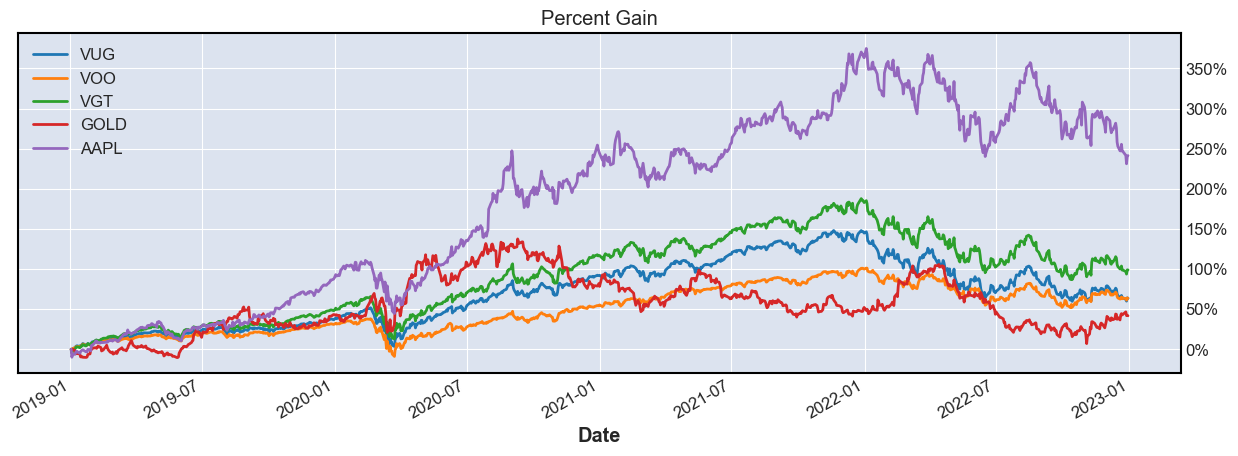

In [45]:
AV_Plots.plot_prct_gain(['VUG', 'VOO', 'VGT', 'GOLD', 'AAPL'], '2019-01-01', '2022-12-31')

In [46]:
# load data from csvs
aapl_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily-full.csv', index_col=0,parse_dates=True)
baba_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\BABA-daily-full.csv', index_col=0,parse_dates=True)
msft_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\MSFT-daily-full.csv', index_col=0,parse_dates=True)
nem_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\NEM-daily-full.csv', index_col=0,parse_dates=True)
tsla_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\TSLA-daily-full.csv', index_col=0,parse_dates=True)
vz_d_source= pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\VZ-daily-full.csv', index_col=0,parse_dates=True)

aapl_d_source.index.rename('Date', inplace=True)
baba_d_source.index.rename('Date', inplace=True)
msft_d_source.index.rename('Date', inplace=True)
nem_d_source.index.rename('Date', inplace=True)
tsla_d_source.index.rename('Date', inplace=True)
vz_d_source.index.rename('Date', inplace=True)

In [47]:
aapl_d_source.head(2)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2023-04-06,162.43,164.9584,162.0,164.66,164.66,45390123,0.0,1.0
2023-04-05,164.74,165.0500,161.8,163.76,163.76,51511744,0.0,1.0


Check if data is actually adjusted for splits and dividends as it should be per the API documentation:

In [48]:
aapl_d_source['8. split coefficient'].value_counts()

1.000000    5892
2.000000       2
4.000000       1
7.000007       1
Name: 8. split coefficient, dtype: int64

In [49]:
splits = aapl_d_source[~aapl_d_source['8. split coefficient'].isin([1])].copy(deep=True)
splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
splits

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2020-08-31,127.58,131.00,126.00,129.04,126.935683,223505733,0.0,4
2014-06-09,92.70,93.88,91.75,93.70,20.831391,75414997,0.0,7
2005-02-28,44.68,45.14,43.96,44.86,1.361730,11635900,0.0,2
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2


Quick check online confirms that these are the dates of the splits for AAPL stock.  
Let's see if the next day's open price is adjusted for the split.

In [50]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,90.56,97.87,89.81,96.62,0.733228,3517900,0.0,1.0
2000-06-20,98.50,103.94,98.37,101.25,0.768364,4476700,0.0,1.0
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2.0
2000-06-22,55.75,57.63,53.56,53.75,0.815794,8352000,0.0,1.0
2000-06-23,53.78,54.63,50.81,51.69,0.784528,3660100,0.0,1.0
2000-06-26,52.50,54.75,52.13,54.13,0.821561,3309900,0.0,1.0


As we can see the column "5. adjusted close" indicates the adjusted close price for the split. Great.   
However to use some of the indicators we need to use the high, low, open and close prices.

Adjusting for the splits:

In [51]:
aapl_d, aapl_splits = AV.adjust_price_for_splits(aapl_d_source)
baba_d, baba_splits = AV.adjust_price_for_splits(baba_d_source)
msft_d, msft_splits = AV.adjust_price_for_splits(msft_d_source)
nem_d, nem_splits = AV.adjust_price_for_splits(nem_d_source)
tsla_d, tsla_splits = AV.adjust_price_for_splits(tsla_d_source)
vz_d, vz_splits = AV.adjust_price_for_splits(vz_d_source)

aapl_d.name = 'AAPL'
baba_d.name = 'BABA'
msft_d.name = 'MSFT'
nem_d.name = 'NEM'
tsla_d.name = 'TSLA'
vz_d.name = 'VZ'
# For Easy access to the data and manipulation
growth = [aapl_d, baba_d, msft_d, tsla_d]
value = [nem_d, vz_d]
all_stocks = [aapl_d, baba_d, msft_d, nem_d, tsla_d, vz_d]

In [52]:
# aapl_d.loc['2000-06-19':'2000-06-26':1]
# aapl_d.loc['2005-02-24':'2005-03-01':1]
aapl_d.loc['2014-06-06':'2014-06-11':1]
# aapl_d_.loc['2020-08-27':'2020-09-02':1]

,Open,High,Low,Close,5. adjusted close,Volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2014-06-06,23.210714,23.259286,23.016786,23.056071,20.503289,12497800,0.0,1.000000
2014-06-09,23.175000,23.470000,22.937500,23.425000,20.831391,75414997,0.0,7.000007
2014-06-10,23.682500,23.762500,23.392500,23.562500,20.953667,62777000,0.0,1.000000
2014-06-11,23.532500,23.690000,23.367500,23.465000,20.866962,45681000,0.0,1.000000


#### Plotting stock price and volume for the last 2 years

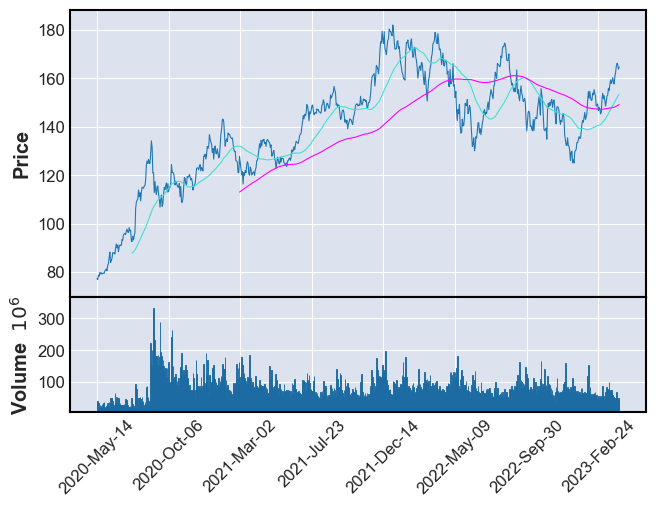

In [53]:
mpf.plot(aapl_d[-730::], type='line',  volume=True,  mav=(50, 200)) # quick plot

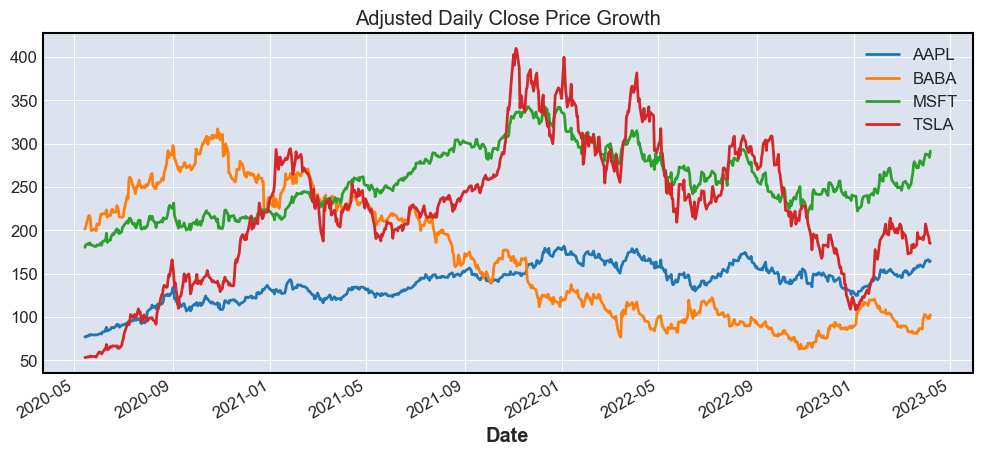

In [54]:
aapl_d['Close'][-730:].plot(figsize=(12,5),label='AAPL', title='Adjusted Daily Close Price Growth')
baba_d['Close'][-730:].plot(label='BABA')
msft_d['Close'][-730:].plot(label='MSFT')
tsla_d['Close'][-730:].plot(label='TSLA')
plt.legend()

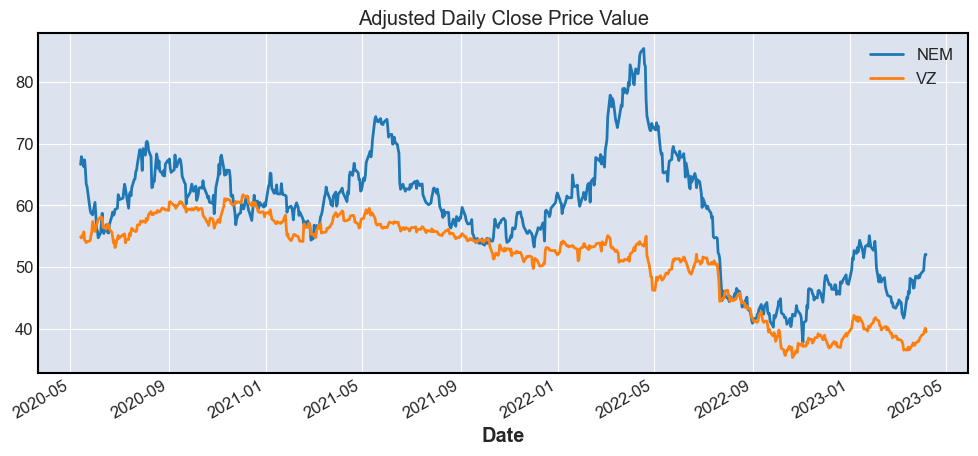

In [55]:
nem_d['Close'][-730:].plot(label='NEM',figsize=(12,5), title='Adjusted Daily Close Price Value')
vz_d['Close'][-730:].plot(label='VZ')
plt.legend()

In [56]:
for stock in all_stocks:
    stock['MA30'] = stock['Close'].rolling(30).mean()
    stock['MA120'] = stock['Close'].rolling(120).mean()

<Axes: title={'center': 'APPL MA30 and MA120'}, xlabel='Date'>

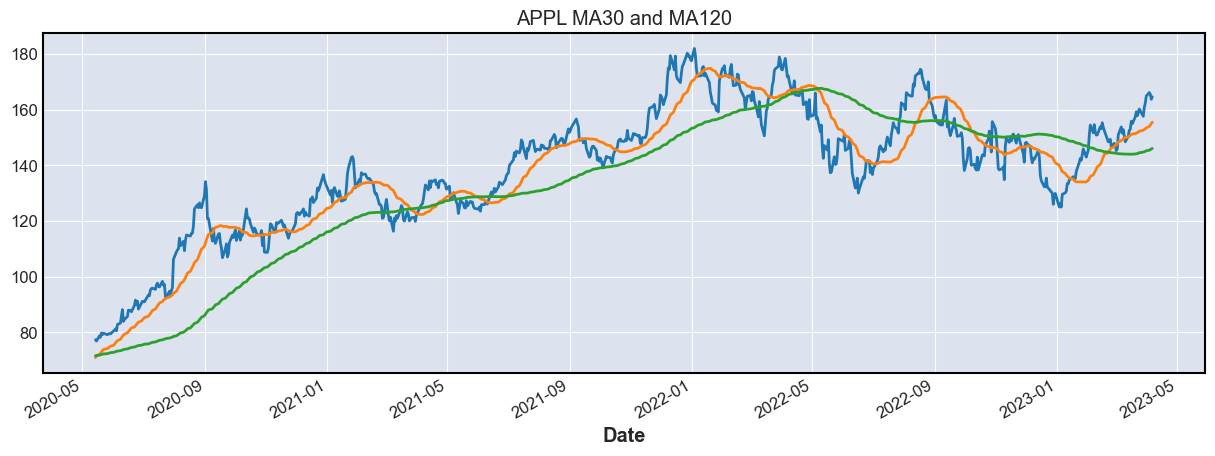

In [57]:
aapl_d['Close'][-730:].plot(figsize=(15,5),label='AAPL', title='APPL MA30 and MA120')
aapl_d['MA30'][-730:].plot(label='MA30')
aapl_d['MA120'][-730:].plot(label='MA120')

#### Conditional probability.
Determining probability of the stock moving up or down based on previous day movement (+2%, +3%, +4%, +5%, +6%) and (-2%, -3%,-4%, -5%, -6%) for different time frames


In [58]:
for stock in all_stocks:
    stock['Daily Return'] = stock['Close'].pct_change() # Calculate the daily returns for each stock into a new column called 'Daily Return'
    conditions = [stock['Daily Return'] < -0.05, 
                stock['Daily Return'].between(-0.05, -0.04, inclusive='left'), 
                stock['Daily Return'].between(-0.04, -0.03, inclusive='left'), 
                stock['Daily Return'].between(-0.03, -0.02, inclusive='left'), 
                stock['Daily Return'].between(-0.02, -0.01, inclusive='left'), 
                stock['Daily Return'].between(-0.01, 0, inclusive='left'), 
                stock['Daily Return'].between(0, 0.01, inclusive='left'), 
                stock['Daily Return'].between(0.01, 0.02, inclusive='left'), 
                stock['Daily Return'].between(0.02, 0.03, inclusive='left'), 
                stock['Daily Return'].between(0.03, 0.04, inclusive='left'), 
                stock['Daily Return'].between(0.04, 0.05, inclusive='left'), 
                stock['Daily Return'] >= 0.05]
    values = [-5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5]
    stock['return bucket'] = np.select(conditions, values)
    stock = stock[~stock['Daily Return'].isnull()] 
for stock in all_stocks:
    # create column called 'UP or DOWN' to indicate whether the stock price increased or decreased and populate it based on the 'return bucket' column
    conditions = [stock['return bucket'].isin([ -1, -2, -3, -4, -5]),
                  stock['return bucket'].isin([0, 1, 2, 3, 4, 5])]
    values = [-1, 1]
    stock['UP or DOWN'] = np.select(conditions, values)

In [59]:
# calculate probability of each return bucket
aapl_d['return bucket'].value_counts(normalize=True)

 0    0.440129
 1    0.148236
-1    0.116350
 2    0.068691
-2    0.067164
 3    0.038501
-3    0.030868
 5    0.027476
-5    0.022218
 4    0.021031
-4    0.019335
Name: return bucket, dtype: float64

* Here is a function which can give us probabilities for stock to go up or down based on previous day percentage change.

In [60]:
def calc_proba_price_change_based(stock_df, percentChange, days, print_proba=False):
    '''Calculates probabilities of a stock to go up or down next day, based on percent change in price of present day.
    '''
    df = stock_df.copy(deep=True)[-days:]
    # shift return bucket column up by one row to match the previous day's return bucket
    df['previous_day_return_bucket'] = df['return bucket'].rolling(2).apply(lambda x: x[0])
    # calculate probability of up or down given previous day's return bucket
    proba_df = df[['previous_day_return_bucket','UP or DOWN']].value_counts(normalize=True).to_frame().rename(columns={0:'Probability'}).pivot_table(columns='previous_day_return_bucket', index='UP or DOWN', values='Probability')
    percentChange = float(percentChange)
    final_series = proba_df[percentChange].rename(index={-1.0:'Negative', 1.0:'Positive'})
    for r in final_series.index:
        if print_proba:
            final_series = final_series / final_series.sum() * 100
            print(f'Probability of {r} is {round(final_series[r],2)}%')
    return proba_df

In [61]:
calc_proba_price_change_based(aapl_d, percentChange=0, days=555, print_proba=True)

Probability of Negative is 25.1%
Probability of Positive is 74.9%


previous_day_return_bucket,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
UP or DOWN,,,,,,,,,,,
-1,0.00361,0.00361,0.009025,0.018051,0.045126,0.113718,0.028881,0.021661,0.007220,0.005415,0.00361
1,0.00361,0.00361,0.036101,0.048736,0.088448,0.339350,0.122744,0.068592,0.019856,0.005415,0.00361


* Calculating colinearity between the stocks

In [62]:
# Make a comparison table for all 5 stocks I have entered above. This should give collinearity.
def compare_stocks(all_stocks, days):
    colinearity_df = pd.DataFrame()
    for stock in all_stocks:
        df = calc_proba_price_change_based(stock, percentChange=0, days=days, print_proba=False)
        df = df.iloc[1].to_frame().T
        df.index = [stock.name] * len(df)
        colinearity_df = pd.concat([colinearity_df, df], axis=0)
    sns.heatmap(colinearity_df.T.corr(), annot=True, cmap='coolwarm')
    return colinearity_df

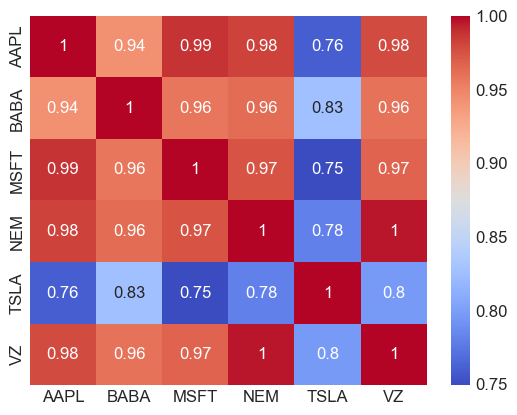

In [63]:
col_df = compare_stocks(all_stocks, days=185*1)

* Function to calculate the probalility of trend going UP or DOWN based on the previous movement over last few days.   
We can use Geometric distribution and PMF - Probability Mass Function from SciPy module to calculate the probability of the stock going up or down based on the previous movement.

In [64]:
aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1] # probability of AAPL going up on any day

0.7440637720488467

In [65]:
up_chance = aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1]
geom.pmf(5, up_chance)

0.003192546409548052

In [66]:
def proba_up_down(stock_df, cont_days, period_days, direction):
    '''Calculates probability of a stock to go on specified direction for a given number of days in a row.
    '''
    if direction == 'up':
        direction_int = 1
    if direction == 'down':
        direction_int = -1
    df = stock_df.copy(deep=True)[-period_days:]
    proba = geom.pmf(cont_days, df['UP or DOWN'].value_counts(normalize=True).loc[direction_int])
    print(f'Probability of {stock_df.name} going "{direction.upper()}" for {cont_days} days in a row is {round(proba*100,3)}%. Based on {period_days} days of data.')

In [67]:
proba_up_down(aapl_d, cont_days=15, period_days=365*10, direction='down')

Probability of AAPL going "DOWN" for 15 days in a row is 0.768%. Based on 3650 days of data.


* Screen through all Nasdaq and NYSE stocks and find the top 10 trending stocks (rank based on percentage change for the day). 	Only for 1 last day.

Scraping data from NASQAD website.

In [68]:
OtherData.get_last_day_data_all_tickers(MARKETS, directory=LAST_DAY_DATA_DIR)

Downloaded nasdaq_last_day.csv
Downloaded nyse_last_day.csv


#### Top 10 trending stocks for the last day.

In [69]:
nasdaq_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nasdaq_last_day.csv')
nyse_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nyse_last_day.csv')

In [70]:
total_markets_fd = pd.concat([nasdaq_df, nyse_df], axis=0)
total_markets_fd.shape 

(7539, 11)

In [71]:
#cleaning data before sorting
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].fillna('0.00%')
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))

0
0


C:\Users\Vasyl\AppData\Local\Temp\ipykernel_26948\1650416781.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))


In [72]:
# Top 10 stocks by any market cap
total_markets_fd.sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
3363,PTPI,Petros Pharmaceuticals Inc. Common Stock,$4.59,3.5800,354.455,9587124.0,United States,NaN,76999262,Health Care,Biotechnology: Pharmaceutical Preparations
3618,SAITW,SAI.TECH Global Corporation Warrant,$0.3478,0.2636,313.064,0.0,Singapore,2021.0,176092,Finance,Investment Bankers/Brokers/Service
1427,EUCRW,Eucrates Biomedical Acquisition Corp. Warrant,$0.0073,0.0053,265.000,0.0,United States,2020.0,801,Finance,Blank Checks
995,CNSP,CNS Pharmaceuticals Inc. Common Stock,$2.35,1.6650,243.066,5231864.0,United States,2019.0,48493913,Health Care,Biotechnology: Pharmaceutical Preparations
3616,SAI,SAI.TECH Global Corporation Class A Ordinary S...,$4.90,3.3800,222.368,110565006.0,Singapore,2021.0,44110008,Finance,Investment Bankers/Brokers/Service
1577,FNVTW,Finnovate Acquisition Corp. Warrants,$0.035,0.0232,196.610,0.0,Cayman Islands,2021.0,350,Finance,Blank Checks
3071,ORIAW,Orion Biotech Opportunities Corp. Warrant,$0.0241,0.0141,141.000,0.0,United States,2021.0,114220,Finance,Blank Checks
2850,NIRWW,Near Intelligence Inc. Warrant,$0.30,0.1677,126.757,0.0,United States,2021.0,276778,Technology,EDP Services
3858,SPCMW,Sound Point Acquisition Corp I Ltd Warrant,$0.0639,0.0339,113.000,0.0,United States,2022.0,703,Finance,Blank Checks
1915,HHGCW,HHG Capital Corporation Warrant,$0.0699,0.0354,102.609,0.0,Hong Kong,2021.0,6185,Finance,Blank Checks


In [73]:
# Top 10 stocks with larger than 5 billion market cap
total_markets_fd[total_markets_fd['Market Cap'] > 5e9].sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
311,BBLN,Babylon Holdings Limited Class A Ordinary Shares,$8.17,0.59,7.784,5.066486e+09,United States,NaN,41636,Health Care,Medical/Nursing Services
1499,JPM,JP Morgan Chase & Co. Common Stock,$138.73,9.74,7.551,4.066816e+11,United States,NaN,43900738,Finance,Major Banks
1438,INSP,Inspire Medical Systems Inc. Common Stock,$261.26,14.29,5.786,7.610612e+09,United States,2018.0,557776,Health Care,Biotechnology: Electromedical & Electrotherape...
3396,QDEL,QuidelOrtho Corporation Common Stock,$94.16,4.49,5.007,6.270409e+09,United States,NaN,1377700,Health Care,Medical Specialities
2135,PKX,POSCO Holdings Inc. American Depositary Shares...,$78.03,3.64,4.893,2.368248e+10,South Korea,1994.0,894955,Industrials,Steel/Iron Ore
506,C,Citigroup Inc. Common Stock,$49.56,2.26,4.778,9.646679e+10,United States,NaN,33052481,Finance,Major Banks
763,DB,Deutsche Bank AG Common Stock,$10.95,0.37,3.497,2.231436e+10,Germany,NaN,3780558,Finance,Commercial Banks
2506,SQM,Sociedad Quimica y Minera S.A. Common Stock,$79.20,2.62,3.421,2.262251e+10,Chile,1993.0,2082826,Industrials,Agricultural Chemicals
285,BAC,Bank of America Corporation Common Stock,$29.52,0.96,3.361,2.361389e+11,United States,NaN,80974751,Finance,Major Banks
408,BLK,BlackRock Inc. Common Stock,$691.33,20.60,3.071,1.038629e+11,United States,1999.0,1117691,Finance,Investment Bankers/Brokers/Service


## Part 2 - Strategy 1 - Finding Most Linear Stocks over 90 days (~60 trading) and Intraday intervals.

#### 1. Find the trending stocks in all Nasdaq indices. Find best linear curve fit for the stocks over last 60 days and plot the results.  
#### 2. Find the trending stocks in all Nasdaq indices. For intraday data, find the best linear curve fit for the stocks over hours 9:30am - 16:00am and plot the results.

2.1 Downloading data for all Nasdaq stocks and saving it in a csv file. Last 100 points (days)

In [74]:
df_nasdaq_100_days = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\NASDAQ All Tickers.csv')
NASDAQ_TICKERS = df_nasdaq_100_days['ticker'].tolist()

In [75]:
# AV.get_daily_adjusted_data_for_list(NASDAQ_TICKERS, key=KEY, full_or_compact='compact')

2.2 Downloading data for all Nasdaq stocks and saving it in a csv files. For 5 min interval. Last 100 points.

In [76]:
AV.get_intraday_data_for_list(tickers_list=NASDAQ_TICKERS, 
                              directory=r'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min', 
                              apikey=KEY, 
                              sleep_time=SLEEP_TIME, 
                              interval='5min', 
                              outputsize='compact')

2.3 Finding stocks trending upwards in the most linear way for Last 60 days for medium term investment analysis.  
* For this we will use Linear Regression from SKLearn module. We will correalte the stock price with the number of days and find the best fit line.  
* We can use the slope of the line to determine the trend. The slope will be positive if the stock is trending upwards and negative if the stock is trending downwards. 
* We will use the R2 score to determine how linear the trend is. The high the R2 score the more linear the trend is. We will use the R2 score to rank the stocks.

In [78]:
df_for_plot = AV.aggregate_close_prices(r'..\P1-Indicators-Chart-Analysis\Data\Daily')

In [79]:
linear_df = Analysis.find_best_linear_stock(df_for_plot)

Filtering the data to get the most linear and the least linear stocks.  
Plotting the results to check if the results make sense.

In [80]:
# Most linear
linear_df.sort_values(by='R2', ascending=False).head(5)

,ticker,R2,slope
576,BIOS,0.970729,0.002880
3757,RDVT,0.962087,-0.144454
703,BURG,0.961641,-0.016684
183,ALLK,0.959187,-0.064203
333,AROW,0.955034,-0.185970


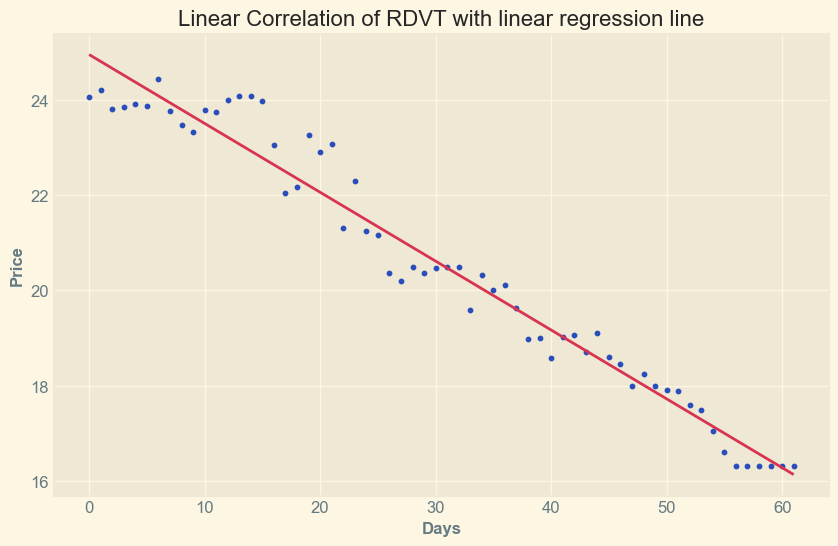

In [83]:
Analysis.plot_correlation(df_for_plot['RDVT'])

In [84]:
# Least Linear 
linear_df.sort_values(by='R2', ascending=False).tail(3)

,ticker,R2,slope
529,BFAM,0.000004,0.000275
2040,GSL,0.000003,0.000078
345,ASC,0.000001,0.000103


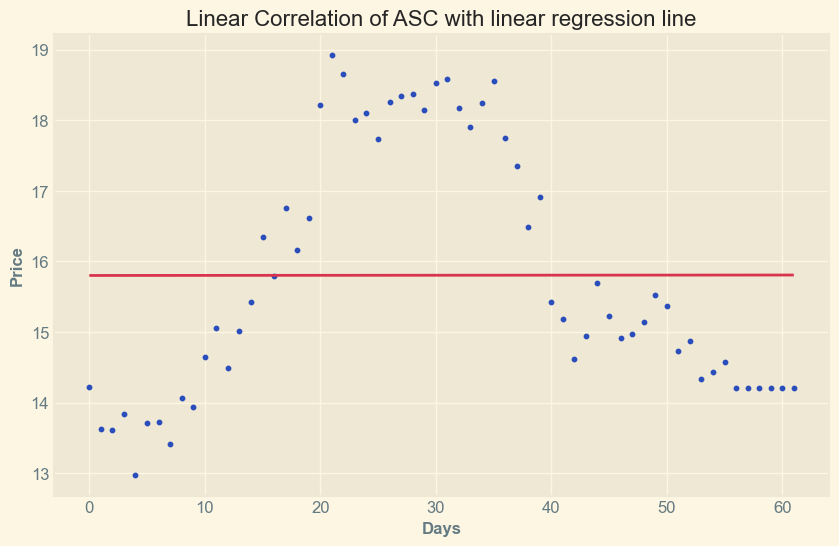

In [87]:
Analysis.plot_correlation(df_for_plot['ASC'])

2.4 Building aggregate dataframe of statistics for intraday 5min data

In [88]:
df_for_plot_intraday = AV.aggregate_close_prices(r'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min', intraday=True)

In [89]:
df_for_plot_intraday.shape

(43, 1469)

In [90]:
linear_df_intraday = Analysis.find_best_linear_stock(df_for_plot_intraday)

In [91]:
# Most linear
linear_df_intraday.sort_values(by='R2', ascending=False).head(5)

,ticker,R2,slope
70,AMGN,0.973555,0.109739
1229,SRDX,0.968070,0.025836
1401,VRTX,0.963356,0.201603
1038,PPC,0.961045,0.018689
395,ECOR,0.960681,0.029524


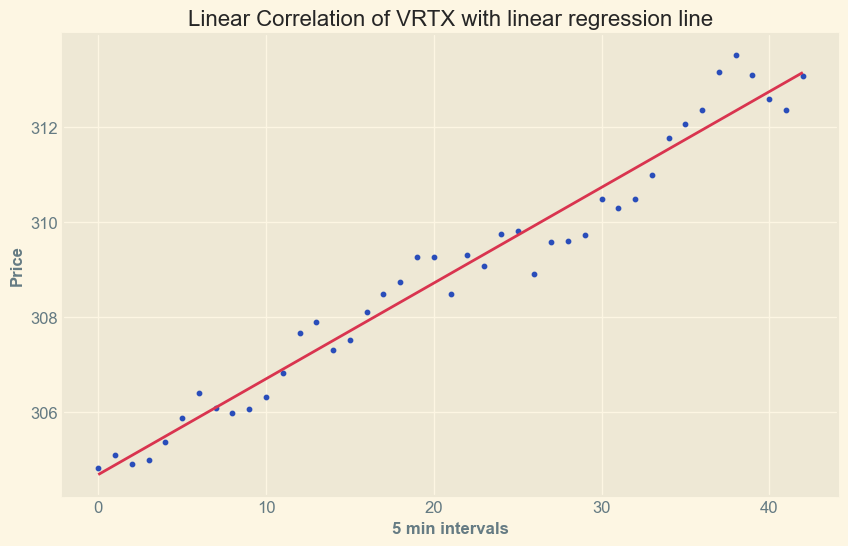

In [92]:
Analysis.plot_correlation(df_for_plot_intraday['VRTX'], intervals='5 min intervals')

In [93]:
# Least Linear
linear_df_intraday.sort_values(by='R2', ascending=False).tail(3)

,ticker,R2,slope
825,MESA,2.574091e-06,2.053760e-06
99,APTO,1.035966e-06,-9.211719e-07
918,NUVA,2.311431e-07,-5.285412e-06


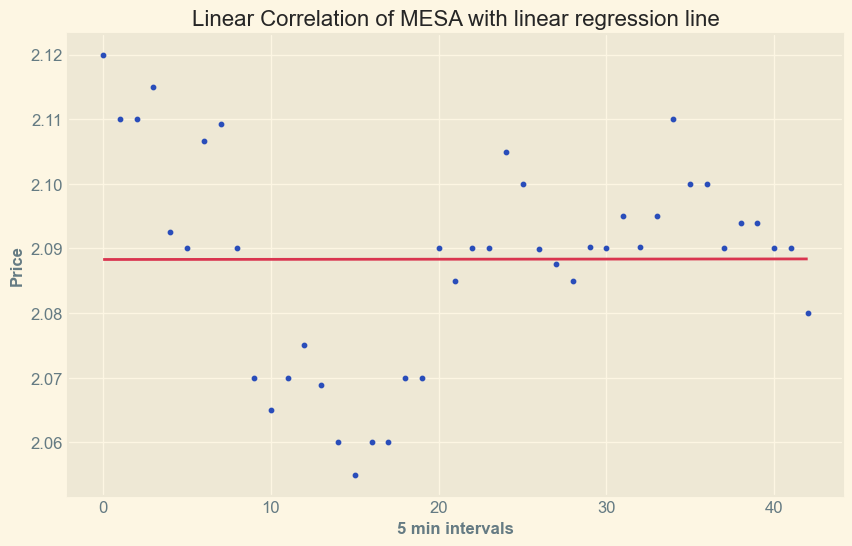

In [94]:
Analysis.plot_correlation(df_for_plot_intraday['MESA'], intervals='5 min intervals')

## Part 3 - Strategy 2 - Finding basic indicators for the stocks and plotting them.

In this section we will use the "ta" library to calculate the indicators for the stocks.
* Using Daily data collected previously we will implement next indicators: 
    * SMA - Simple Moving Average
    * EMA - Exponential Moving Average (Exponential)
    * WMA - Weighted Moving Average (Linear)
    * AMA - Adaptive Moving Average (Reacts to volatility faster than other moving averages) - Kaufman Adaptive Moving Average
    * MACD - Moving Average Convergence Divergence
    * RSI - Relative Strength Index
    * Bollinger Bands
    * OBV - On Balance Volume

In [95]:
# Load data
df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily-full.csv', index_col=0, parse_dates=True)

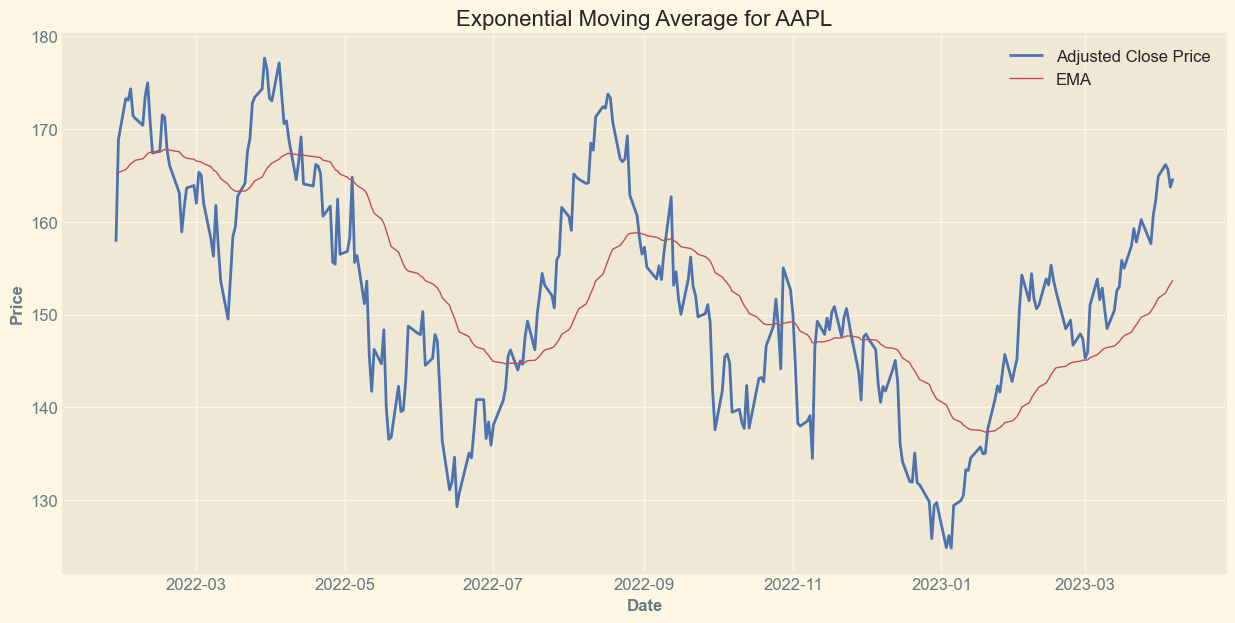

In [96]:
_ = Ind.calc_plot_EMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

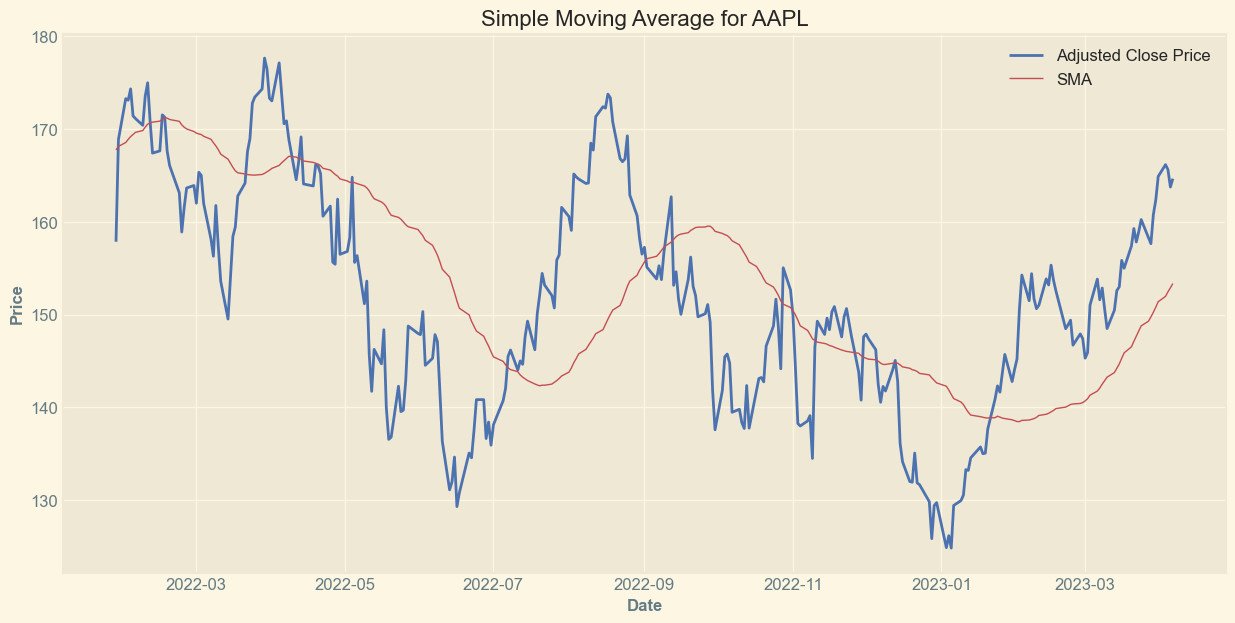

In [97]:
_ = Ind.calc_plot_SMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

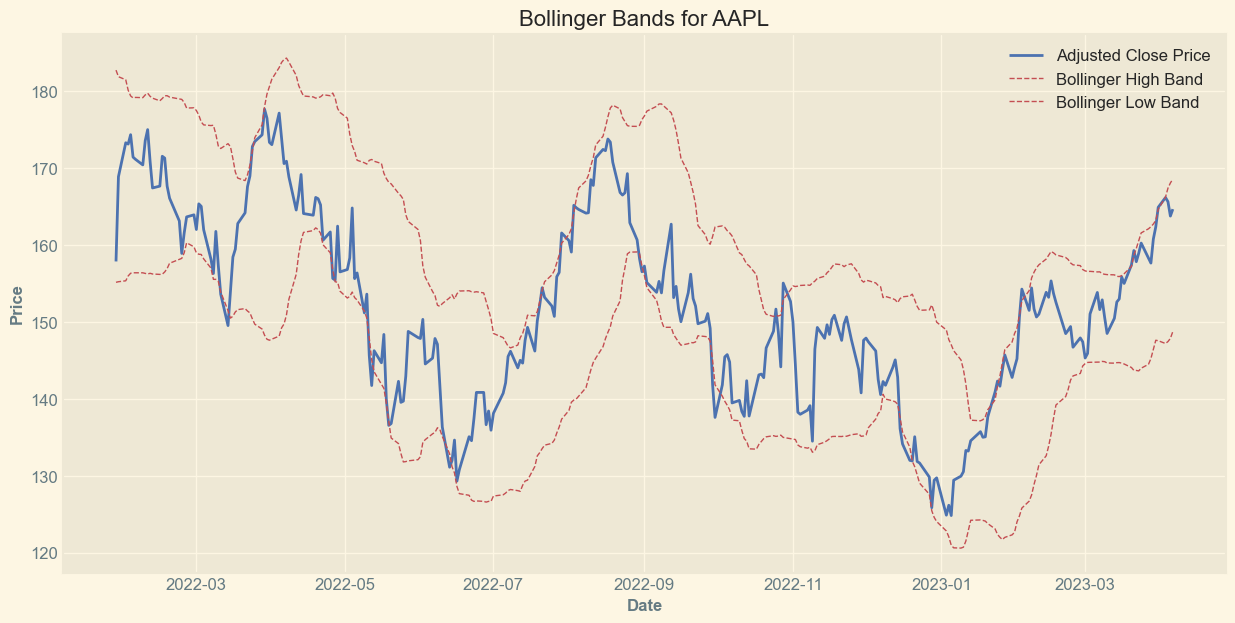

In [98]:
_= Ind.calc_plot_BollingersBands(df, stock_name='AAPL',window=20, plot=True, plot_days_back=300)

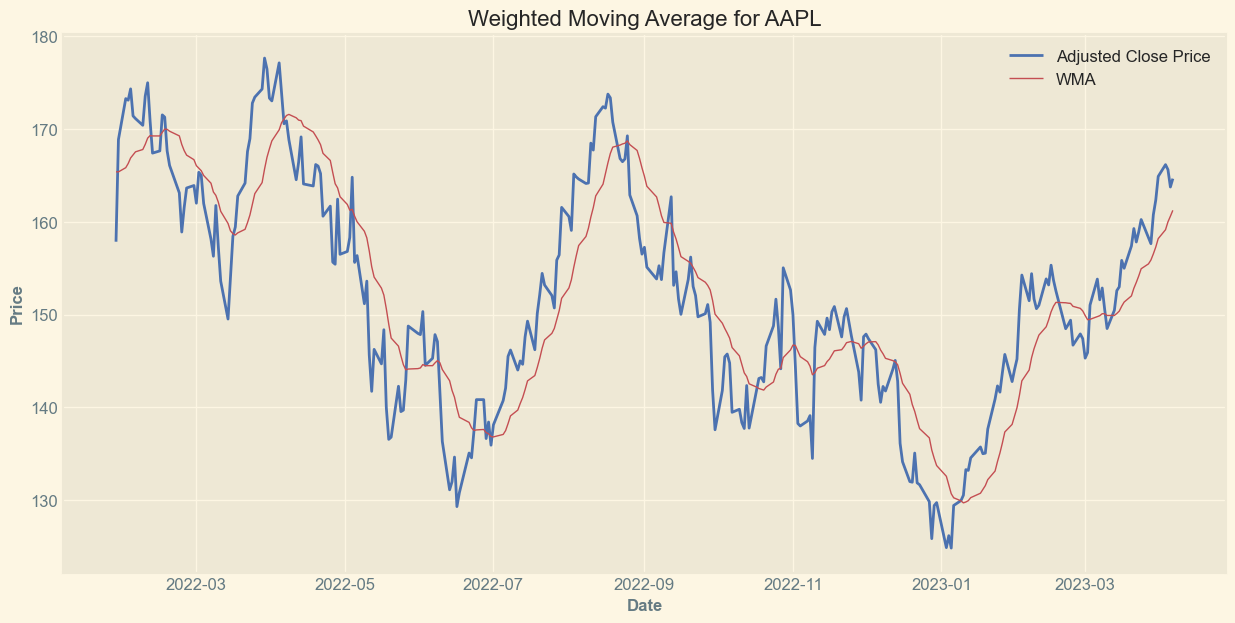

In [99]:
_= Ind.calc_plot_WMA(df, stock_name='AAPL',window=20, plot=True, plot_days_back=300)

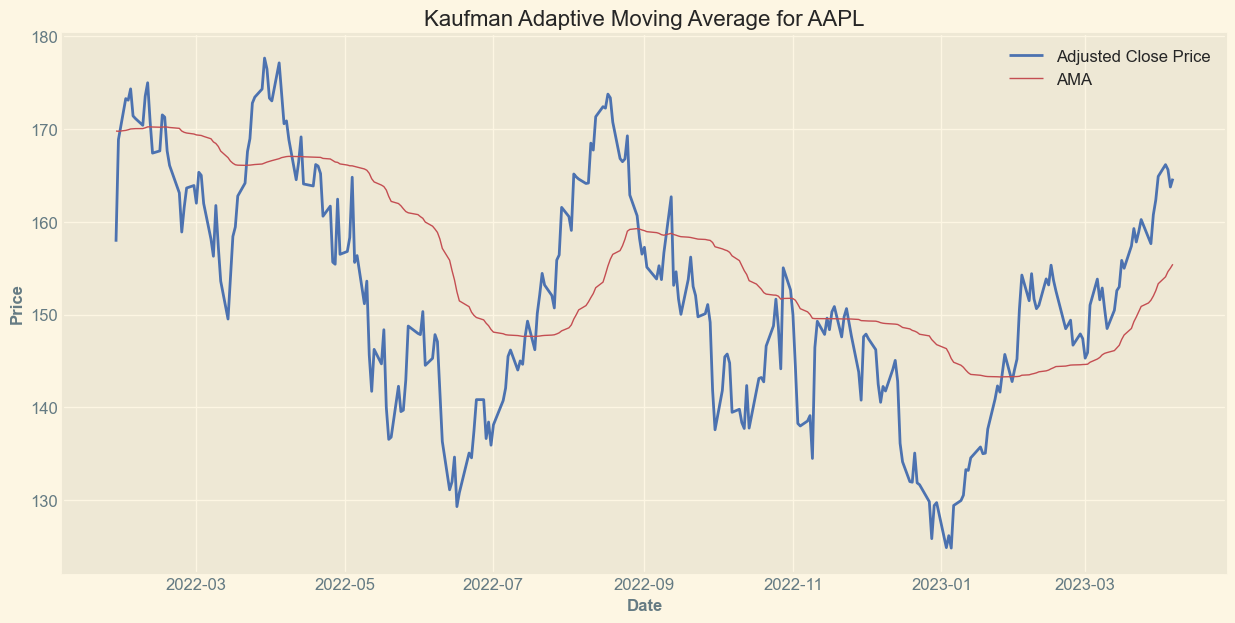

In [100]:
_= Ind.calc_plot_AMA(df, stock_name='AAPL', window=50, plot=True, plot_days_back=300)

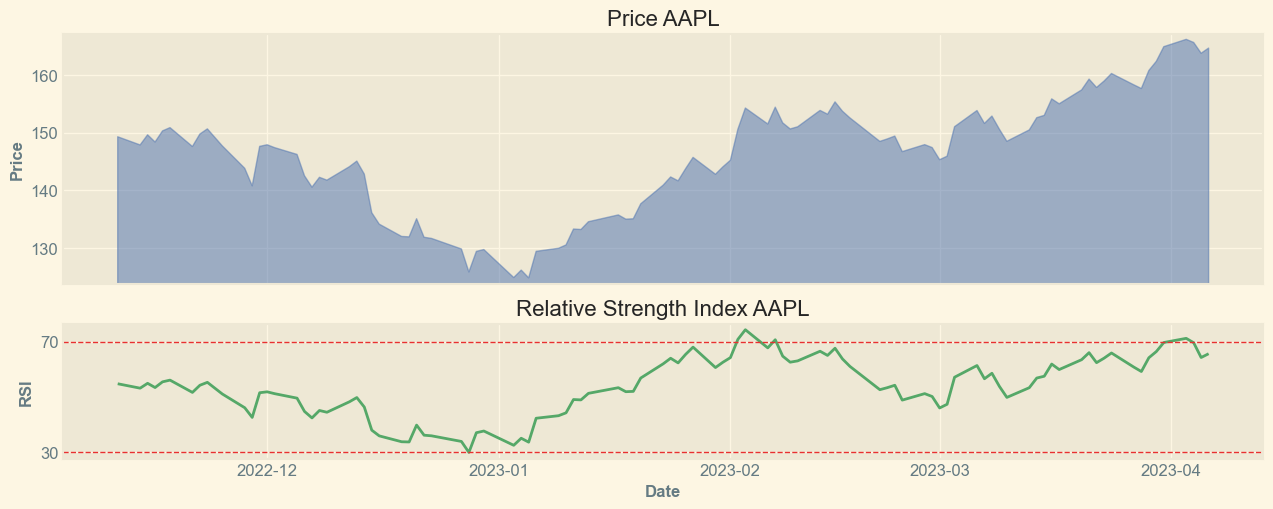

In [101]:
_= Ind.calc_plot_RSI(df, stock_name='AAPL', window=14, plot=True, plot_days_back=100)

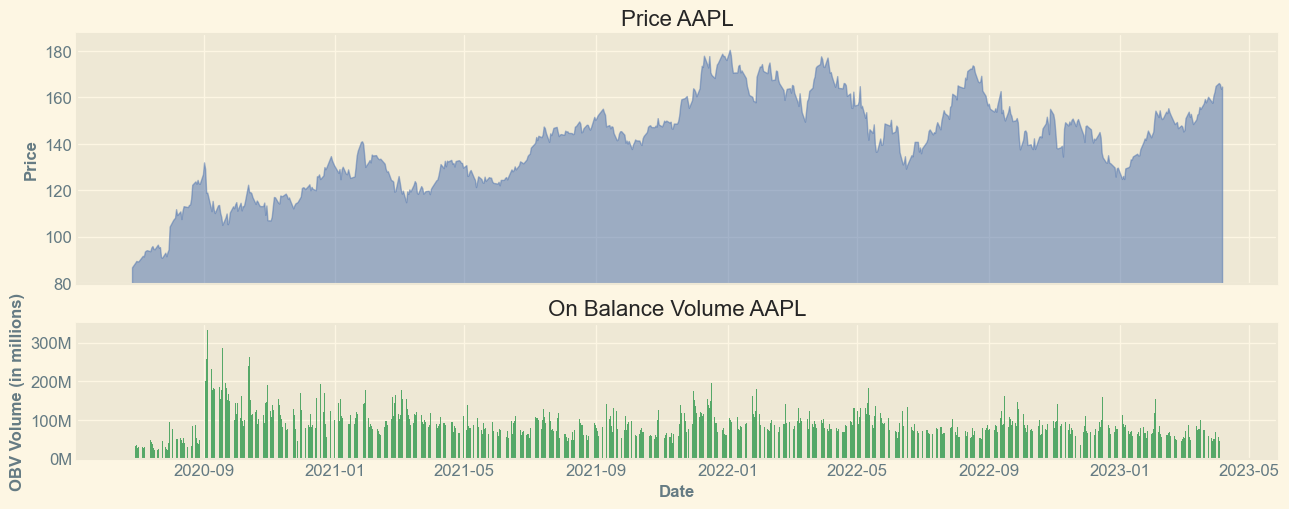

In [102]:
_= Ind.calc_plot_OBV(df, stock_name='AAPL', plot=True, plot_days_back=700)

#### 4.1 Data Load. Preparation.

In [108]:
def load_stock_data(stock_name, directory=r'..\P1-Indicators-Chart-Analysis\Data\Daily'):
    ''' Loads stock data from directory and performs some cleaning.'''
    stock_df_source = pd.read_csv(os.path.join(directory, f'{stock_name}-daily-full.csv'), index_col=0, parse_dates=True)
    stock_df, stock_splits = AV.adjust_price_for_splits(stock_df_source)
    stock_df.name = stock_name
    stock_df = stock_df[['5. adjusted close','Volume']]
    stock_df.columns = ['Close','Volume']
    return stock_df

In [110]:
df = load_stock_data('VZ')

#### 4.1.1 Ploting some data to see how it looks like.

<Axes: title={'center': ' VZ Adjusted Daily Close Price Growth'}, xlabel='Date'>

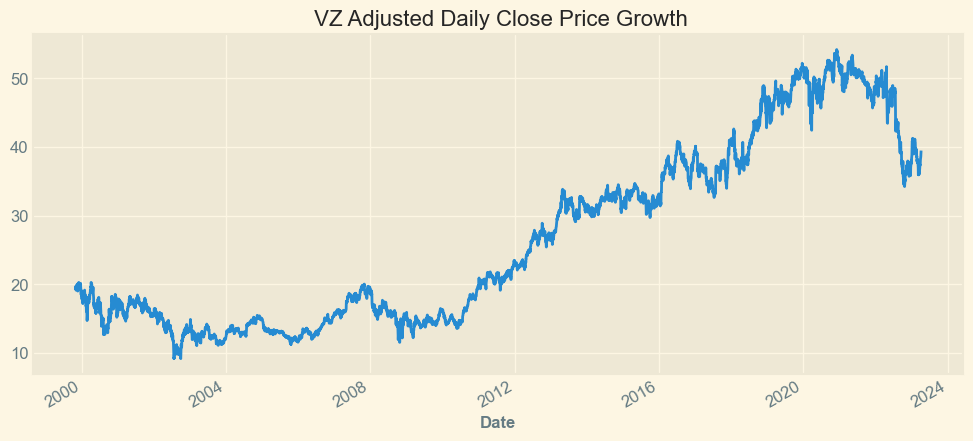

In [111]:
# Glance on a Price chart
df['Close'][:].plot(figsize=(12,5), title=' VZ Adjusted Daily Close Price Growth')

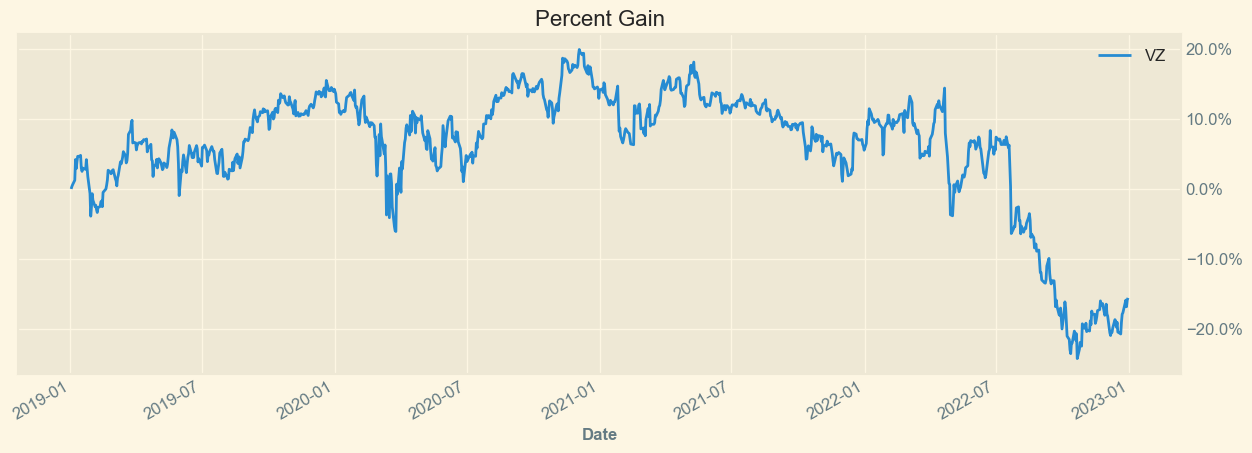

In [112]:
# Glance on the % change over time
AV_Plots.plot_prct_gain(['VZ'], '2019-01-01', '2022-12-31')

Glance on ACF - Autocorrelation Function and PACF - Partial Autocorrelation Function

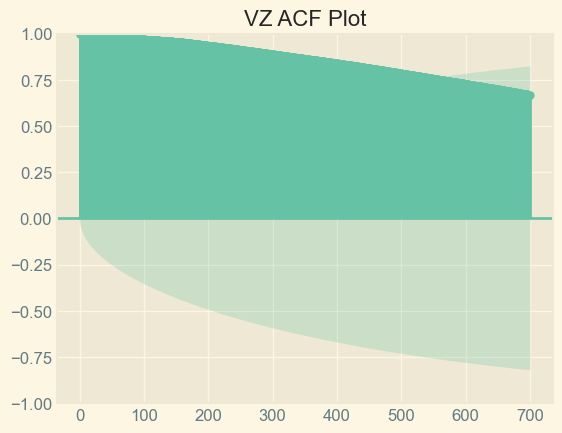

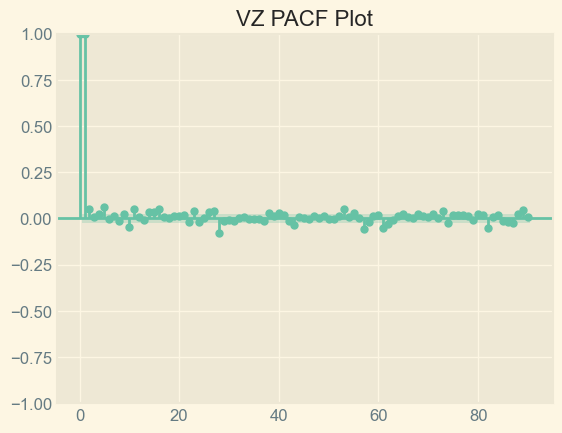

In [146]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
figure_AXF = plot_acf(df['Close'], lags=700, title='VZ ACF Plot')
figure_AXF = plot_pacf(df['Close'], lags=90, title='VZ PACF Plot')


#### 4.2.1 Adding some Technical Indicators to the data.

The Kaufman's Adaptive Moving Average (KAMA) is a technical indicator used in stock market analysis. It is a type of moving average that adjusts its smoothing factor based on market volatility, aiming to provide more accurate and responsive signals in varying market conditions.

In [113]:
df['KAMA'] = Ind.calc_plot_AMA(df, stock_name='VZ', col='Close',  window=20, plot=False, plot_days_back=200)

The RSI (Relative Strength Index) is a popular technical indicator used in stock market analysis to measure the strength of price movements and identify potential overbought or oversold conditions in a security.

In [114]:
df['RSI'] = Ind.calc_plot_RSI(df, stock_name='VZ', col='Close', window=20, plot=False, plot_days_back=200)

On Balance Volume:  
* OBV = OBV_previous + Volume_current

Where:

OBV_previous: The OBV value from the previous period.
Volume_current: The volume of the current period. If the current period's closing price is higher than the previous period's closing price, then the volume is added to OBV_previous. If the current period's closing price is lower than the previous period's closing price, then the volume is subtracted from OBV_previous. If the current period's closing price is the same as the previous period's closing price, then OBV remains unchanged.

In [115]:
df['OBV'] = Ind.calc_plot_OBV(df, stock_name='VZ', close_col='Close', volume_col='Volume', plot=False, plot_days_back=200)

Bollinger Bands:  
Upper Band: This is the upper line of the Bollinger Bands and is calculated by adding a certain number of standard deviations (usually 2) to the middle band. The upper band represents the upper limit of expected price movement, and it tends to contain most of the price data within its range.

Lower Band: This is the lower line of the Bollinger Bands and is calculated by subtracting a certain number of standard deviations (usually 2) from the middle band. The lower band represents the lower limit of expected price movement.

In [116]:
df_temp = Ind.calc_plot_BollingersBands(df, stock_name='VZ', col = 'Close', window=20,window_dev=2, plot=False, plot_days_back=200)
df[['BB_H', 'BB_L']] = df_temp[['bb_bbh', 'bb_bbl']]

#### 4.2.2 Adding our own features to the data.

In [117]:
# Adding month number column
df['Month'] = df.index.month

4.4 Adding some fundamental data to the data.
Skipping for now. Will add later.

#### 4.3 Checking for colinearity between the features.

In [118]:
df

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Date,,,,,,,,
1999-11-01,19.778786,4260300,NaN,NaN,4260300,NaN,NaN,11
1999-11-02,19.336802,2668800,NaN,NaN,1591500,NaN,NaN,11
1999-11-03,19.490268,2965100,NaN,NaN,4556600,NaN,NaN,11
1999-11-04,19.223236,2207800,NaN,NaN,2348800,NaN,NaN,11
1999-11-05,19.125018,4171900,NaN,NaN,-1823100,NaN,NaN,11
...,...,...,...,...,...,...,...,...
2023-03-31,38.257701,22801450,36.903487,54.636435,870906591,38.290466,35.515713,3
2023-04-03,38.582336,19354856,36.948696,56.980602,890261447,38.504646,35.406794,4
2023-04-04,39.005345,18577085,37.049905,59.827924,908838532,38.826586,35.256024,4


In [119]:
# Check for collinearity between the features
df.corr('pearson').style.background_gradient(cmap='coolwarm')

,Close,Volume,KAMA,RSI,OBV,BB_H,BB_L,Month
Close,1.000000,0.195245,0.998121,0.053348,0.921148,0.996989,0.996823,-0.003208
Volume,0.195245,1.000000,0.201189,-0.062222,0.228631,0.201968,0.196570,-0.092328
KAMA,0.998121,0.201189,1.000000,0.004855,0.918833,0.998900,0.998516,-0.005338
RSI,0.053348,-0.062222,0.004855,1.000000,0.104851,0.001414,0.004813,0.052566
OBV,0.921148,0.228631,0.918833,0.104851,1.000000,0.914859,0.920788,0.006686
BB_H,0.996989,0.201968,0.998900,0.001414,0.914859,1.000000,0.995822,-0.006546
BB_L,0.996823,0.196570,0.998516,0.004813,0.920788,0.995822,1.000000,-0.002136
Month,-0.003208,-0.092328,-0.005338,0.052566,0.006686,-0.006546,-0.002136,1.000000


#### 4.4 Creating Linear Regression model.  Splitting the data into train and test sets. 

In [120]:
df = df.dropna()
X = df.drop(['Close'], axis=1)
y = df['Close']

In [121]:
print (X.shape, y.shape)

(5877, 7) (5877,)


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=False)

In [123]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4701, 7) (4701,)
(1176, 7) (1176,)


In [124]:
linear_model = LinearRegression().fit(X_train, y_train)

In [125]:
print(f'R^2: {linear_model.score(X_test, y_test)}')

R^2: 0.9662891774310134


In [126]:
linear_model_pred_price = linear_model.predict(X_test)
linear_model_pred_price = pd.DataFrame(linear_model_pred_price, index=y_test.index, columns = ['price']) 

In [127]:
linear_model_pred_price

,price
Date,
2018-08-06,41.526727
2018-08-07,41.566929
2018-08-08,41.692521
2018-08-09,41.861756
2018-08-10,41.626940
...,...
2023-03-31,37.078813
2023-04-03,37.286170
2023-04-04,37.565979


<Axes: title={'center': 'VZ Pred Price'}, xlabel='Date', ylabel='price'>

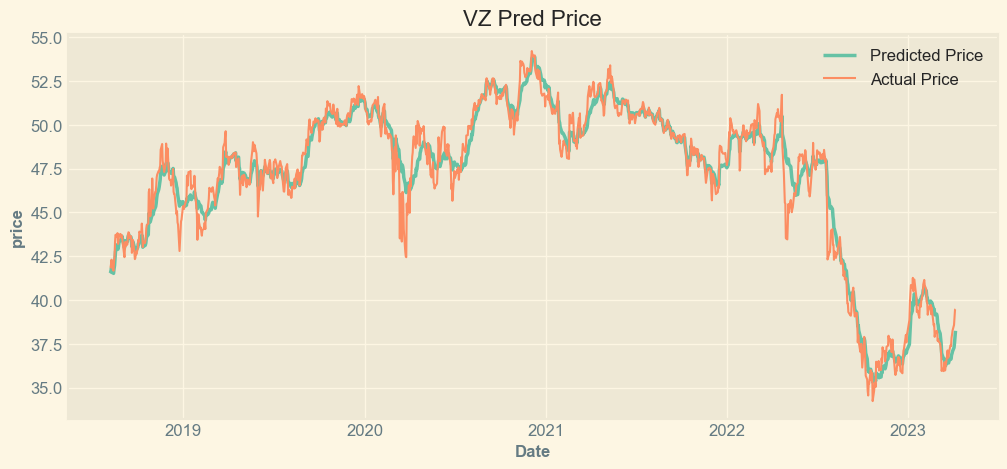

In [129]:
plt.figure(figsize=(12,5))
plt.title('VZ Pred Price')

sns.set_palette("Set2")
sns.lineplot(data=linear_model_pred_price['price'], linewidth=2.5, label='Predicted Price')
sns.lineplot(data=y_test, linewidth=1.5, label='Actual Price')

#### 4.5 Creating LSTM - Long Short Term Memory Neural Network model.

In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

config = {
    "alpha_vantage": {
        "key": KEY, # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.70,
        "val_split_size": 0.2,
        "test_split_size": 0.1,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

4.5.1 Downloading data for 1 stock for our model.

In [149]:
def download_data(config):
    ts = TimeSeries(key=config['alpha_vantage']['key']) #you can use the demo API key for this project, but please make sure to eventually get your own API key at https://www.alphavantage.co/support/#api-key. 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5901 from 1999-11-01 to 2023-04-14


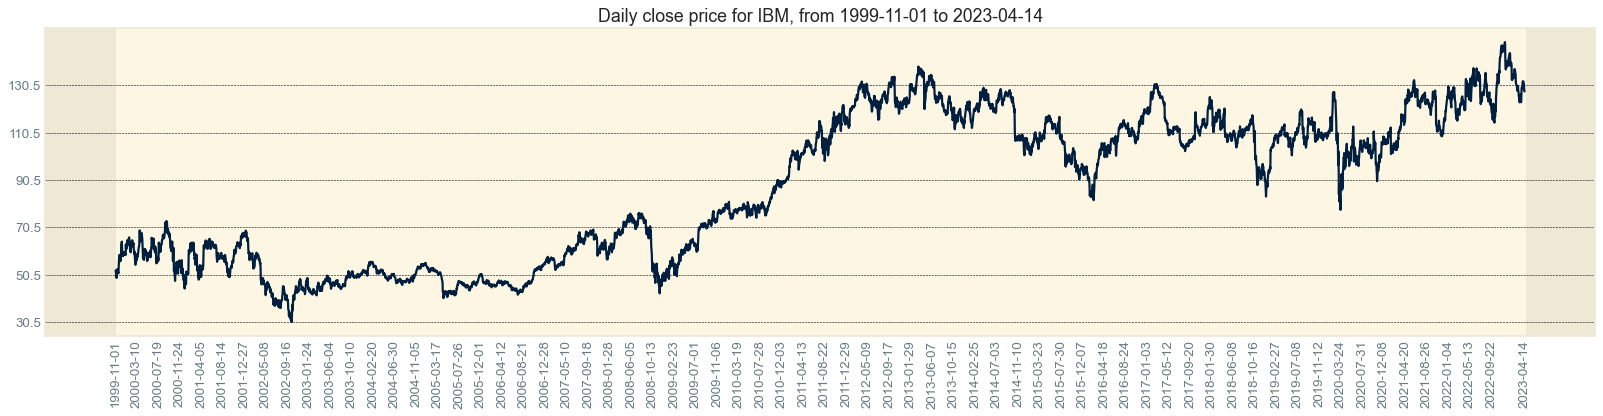

In [161]:
# plot
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.yticks(np.arange(min(data_close_price), max(data_close_price), 20))
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)

plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')

plt.show()

#### 4.5.2 Preparing data for LSTM model.

Standardize the data.

In [193]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
normalized_data_close_price = scaler.fit_transform(data_close_price.reshape(-1, 1))
# reshape back to 1D array
normalized_data_close_price = normalized_data_close_price.reshape(-1)

#### 4.5.3 Splitting the data into train, test and validation sets.

In [190]:
def prepare_data_x(x, window_size):
    # perform windowing
    print("x shape", x.shape)
    n_row = x.shape[0] - window_size + 1
    print("Number of rows", n_row)
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    
    print ("Output shape", output.shape)
    print('Srtides', x.strides)
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    print("y shape", output.shape)
    return output

In [191]:

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

x shape (5901,)
Number of rows 5882
Output shape (5882, 20)
Srtides (8,)
y shape (5881,)


In [188]:
print(data_x[0])
print(data_x[1])

[-1.12476993 -1.15894365 -1.16669438 -1.21619342 -1.23926949 -1.17215513
 -1.17779923 -1.11818341 -1.15345905 -1.13811414 -1.17003859 -1.16016142
 -1.17550632 -1.10054559 -0.99577695 -0.92646033 -0.95838478 -0.98589978
 -0.97708087 -0.9913675 ]
[-1.15894365 -1.16669438 -1.21619342 -1.23926949 -1.17215513 -1.17779923
 -1.11818341 -1.15345905 -1.13811414 -1.17003859 -1.16016142 -1.17550632
 -1.10054559 -0.99577695 -0.92646033 -0.95838478 -0.98589978 -0.97708087
 -0.9913675  -1.01129823]


In [195]:
# split dataset into train, validation, and test
train_size = int(len(data_x) * config["data"]["train_split_size"])
val_size = int(len(data_x) * config["data"]["val_split_size"])
test_size = len(data_x) - train_size - val_size
print("Train size", train_size)
print("Val size", val_size)
print("Test size", test_size)

data_x_train = data_x[:train_size]
data_y_train = data_y[:train_size]

data_x_val = data_x[train_size:train_size+val_size]
data_y_val = data_y[train_size:train_size+val_size]

data_x_test = data_x[train_size+val_size:]
data_y_test = data_y[train_size+val_size:]

print('Sum of train, val, test', len(data_x_train) + len(data_x_val) + len(data_x_test))

Train size 4116
Val size 1176
Test size 589
Sum of train, val, test 5881


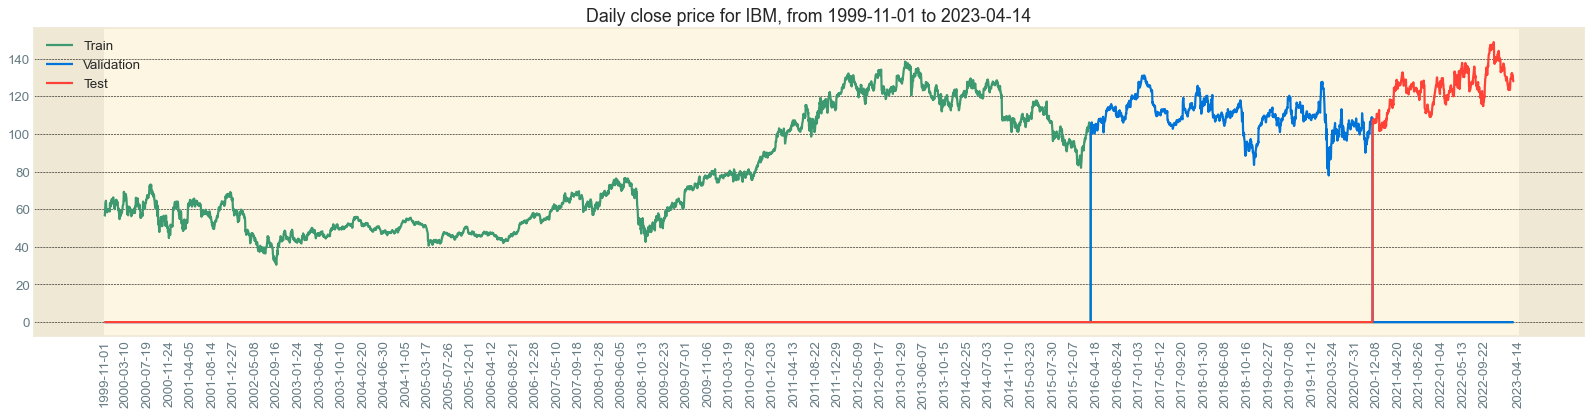

In [211]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))
to_plot_data_y_val = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))
to_plot_data_y_test = np.zeros(len(data_x_train) + len(data_x_val) + len(data_x_test))

to_plot_data_y_train[:len(data_y_train)] = scaler.inverse_transform(data_y_train.reshape(-1, 1)).reshape(-1)
to_plot_data_y_val[len(data_y_train):len(data_y_train)+len(data_y_val)] = scaler.inverse_transform(data_y_val.reshape(-1, 1)).reshape(-1)
to_plot_data_y_test[len(data_y_train)+len(data_y_val):] = scaler.inverse_transform(data_y_test.reshape(-1, 1)).reshape(-1)

# plot 
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_train, color=config["plots"]["color_train"])
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_val, color=config["plots"]["color_val"])
plt.plot(data_date[:-config['data']['window_size']], to_plot_data_y_test, color=config["plots"]["color_test"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')

plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='black')
plt.legend(['Train', 'Validation', 'Test'])

plt.show()


#### 4.5.4 Creating DataLoader object for the data.

In [ ]:
# implement LSTM model in Keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True, input_shape=(config["data"]["window_size"], 1)))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"], return_sequences=True))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(LSTM(units=config["model"]["lstm_units"]))
model.add(Dropout(config["model"]["dropout_rate"]))
model.add(Dense(units=1))

model.compile(optimizer=config["model"]["optimizer"], loss=config["model"]["loss"])
model.summary()
